# Proyecto

In [2]:
#1. Como primer paso partimos de instalar las librerias necesarias para este proyecyto, las cuales aparecen a continuación:

#import esda 
import pandas as pd
import geopandas as gpd
#import libpysal as lps
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from shapely.geometry import MultiPolygon, Polygon
from json import loads

In [127]:
# Creamos una función que genere los poligonos de la cdmx con la información que necesitamos, mediante un metodo constructor que genera "objetos" para este caso practico nuestro objeto son los poligonos, los cuales son formas geometricas que delimitan la forma que tienen las delegaciones. A estos obejetos les corresponde información contenida en la base de datos predial; es decir, a la información predial de Tlalpan (atributos) le asiganmos un poligono (objeto)  

def csv2shp (df): #Definimos la función como "csv2shp"
    pols=[] #creamos una lista vacia que almacenara los poligonos
    for i in df.geo_shape: #Creamos un ciclo iterativo que genera la información de los poligonos que irán a la lista antes mencionada 
        pol=loads(i)['coordinates'][0] #Creamos una variable llamada "pol" que almacenara las coordenadas de los poligonos, esto es importante porque vuelve la información espacial. 
        if len(pol)<2: #Usamos if para el ciclo y quiere decir que en tanto se tengan menos de 2 poligonos se concretara el proceso de extraer las coordenadas para esa geometria   
            pols.append(Polygon(pol[0])) #Polygon es un metodo constructor de la libreria "shapely.geometry"
        else: #Else le indica al programa que hacer en caso de que se encuentre un multipoligono  
            multis= [] #Es una lista vacia que almacenara aquellas geometrias que se compongan de poligonos compuestos de varias geometrias a lo cual llamamos multipoligono  
            for j in pol: #ciclo para los multipoligonos 
                multis.append(Polygon(j)) #Implementa el metodo constructor en los multipoligonos 
            pols.append(MultiPolygon(multis)) #Añade los multipoligonos procesasdos a la lista de poligonos para tener nuestros datos completos 

    df['geometry']= pols #En la tabala que construimos llamada "df" almacenamos los datos procesados en el paso anterior  
    gdf= gpd.GeoDataFrame(df,crs='EPSG:4326').drop(columns='geo_shape') #Creamos una variable llamada gdf que almacenará la proyección geografica asignada a los datos en la tabla df
    
    return gdf #Regresa los datos procesados en la forma deseada 

In [143]:
def predio2ageb(cat,agebF):
    cat['geometry']=cat.geometry.representative_point()
    preRes=gpd.sjoin(agebF,cat).reset_index(drop=True).drop(columns=['index_right','fid','codigo_pos','colonia_pr','CVE_MUN'])
    preRes=preRes.groupby('CVEGEO')[['superficie','anio_const','valor_unit']].mean().reset_index()
    res= pd.merge(preRes, agebF[['CVEGEO','geometry']], on='CVEGEO')
    res.crs = cat.crs
    
    return res

### Crear archivos shp con datos catastrles a nivel predio CDMX

In [ ]:
#Para crear el mapa que nos muestre los valores prediales de la cdmx no contamos con datos que nos proporcione directamente esta información, pero podemos construir los datos a partir de dos conjuntos, uno que nos da la información espacial (geografica) y el otro nos da la base de datos de los valuos prediales.
#Creamos una variable llamada csv para almacenar todos los archivos csv (contienen la información predial) esto debido a que se tiene un archivo csv por cada delegación
csv= glob('Data/*.csv')

In [147]:
for i in tqdm(csv): #Creamos un ciclo para dar tratamiento a los datos en crudo, lo que se hizo fue extraer los datos que nos sirven para  el proyecto e  indicar el tipo de dato que es; es decir diferenciar entre los valores que son palabaras y  los que son números, es importante ya que así podremos realizar operaciones matematicas. 
    df= pd.read_csv(i, usecols= ['fid','codigo_postal','superficie_terreno','valor_unitario_suelo','geo_shape','colonia_predio','anio_construccion'],
                    dtype= {'fid':str,'codigo_postal':str,'superficie_terreno':float,'valor_unitario_suelo':float,'geo_shape':str,'colonia_predio':str,'anio_construccion':float})

    df= df[~df.geo_shape.isna()].copy() #Elimina aquellos datos que carecen de información espacial

    gdf= csv2shp(df).to_crs('EPSG:32614') #Asignamos la proyección geografica correspondiente a la zona utm de la CDMX

    gdf.to_file('Data/Outputs/{}.shp'.format(i[i.find('mx_')+3:i.find('_08')].replace(" ","_"))) #Indicamos que los resulados obetnidos deben almacenarce en un archivo llamado "Outputs"

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [14:38<00:00, 54.90s/it]


### Juntar con archivos AGEB 

In [103]:
ageb= gpd.read_file('Data/conjunto_de_datos/09a.shp')[['CVEGEO','geometry','CVE_MUN']] #Creamos una varibbale llamada ageb que almacenará los archivos shp de la ciudad de México, los cuales contienen la información que hace a nuestros datos espaciales

In [104]:
agebR= gpd.read_file('Data/conjunto_de_datos/09ar.shp').to_crs('EPSG:32614')[['CVEGEO','geometry','CVE_MUN']]

In [105]:
ageb.crs # Podemos  observar que los datos crudos se encuentran en un sistema de coordenadas conocido como "CCL" esto debido a que la información se produce así. Debemos pasarlo a un sistema conocido como UTM para poder realizar metricas estadisticas con los datos, así la información que se produzca será entendible 

<Projected CRS: PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["GCS_ITRF_200 ...>
Name: MEXICO_ITRF_2008_LCC
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: International Terrestrial Reference Frame 2008
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [106]:
ageb= ageb.to_crs('EPSG:32614') #Comando para reproyectar los datos 

In [107]:
ageb.crs #Podemos observar que los datos ya estan transformados y de esta forma podemos comenzar a hacer metricas estadisticas 

<Projected CRS: EPSG:32614>
Name: WGS 84 / UTM zone 14N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 102°W to 96°W - by country
- bounds: (-102.0, 0.0, -96.0, 84.0)
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [108]:
ageb= ageb.append(agebR).reset_index(drop=True)

### Filtramos información 

In [110]:
cveMun= {'ALVARO_OBREGON':'010','AZCAPOTZALCO':'002','BENITO_JUAREZ':'014','COYOACAN':'003',
         'CUAJIMALPA_DE_MORELOS':'004','CUAUHTEMOC':'015','GUSTAVO_A._MADERO':'005','IZTACALCO':'006',
         'IZTAPALAPA':'007','MAGDALENA_CONTRERAS':'008','MIGUEL_HIDALGO':'016','MILPA_ALTA':'009',
         'TLAHUAC':'011','TLALPAN':'012','VENUSTIANO_CARRANZA':'017','XOCHIMILCO':'013'}

In [111]:
ruts=glob('Data/Outputs/*.shp')

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [04:33<00:00, 17.08s/it]


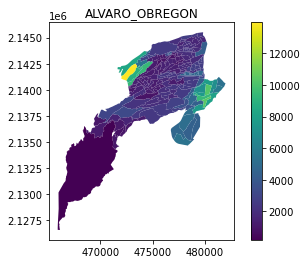

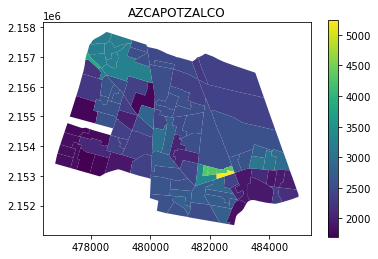

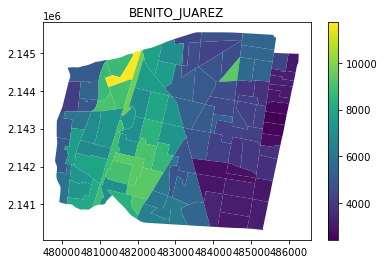

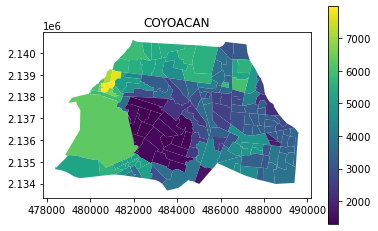

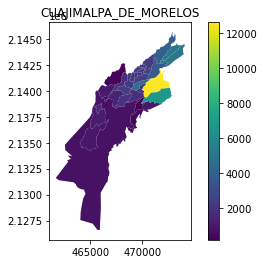

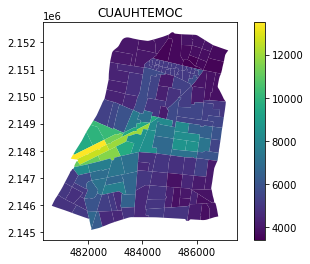

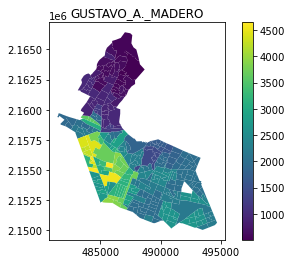

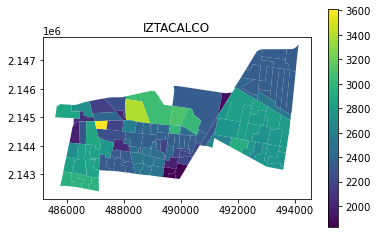

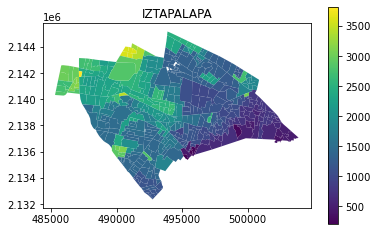

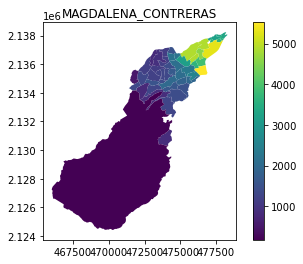

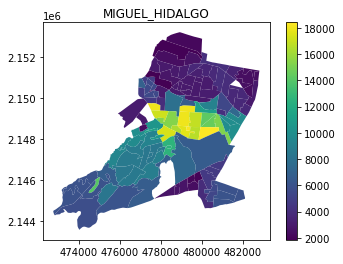

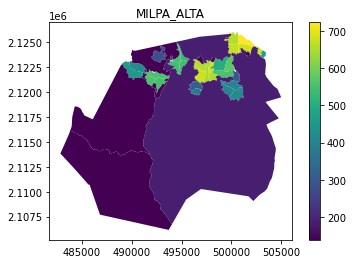

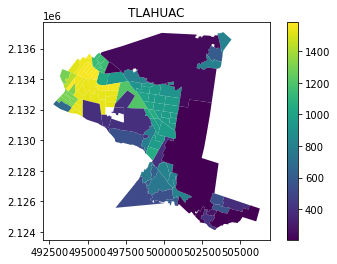

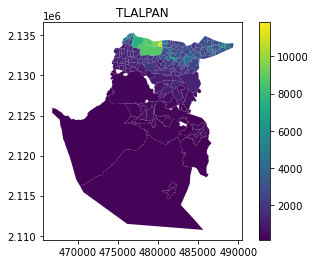

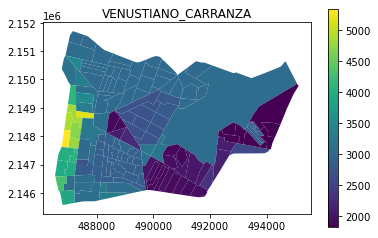

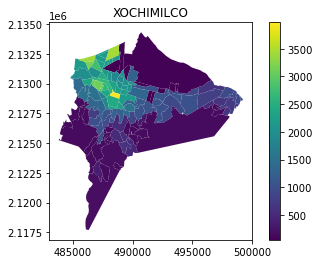

In [146]:
for i in tqdm(ruts):
    name=i[13:-4]
    agebF=ageb[ageb.CVE_MUN==cveMun[name]]
    cat=gpd.read_file(i)
    cat=cat[~((cat.valor_unit.isna()) | (cat.valor_unit==0))].copy()
    
    res = predio2ageb(cat,agebF)
    
    res.plot(column='valor_unit',legend=True)
    plt.title(name)
    
    res.to_file('Data/Outputs/CatastroAGEB/{}_cat.shp'.format(name))